In [1]:
import os
import pandas as pd
if os.path.basename(os.path.abspath(".")) == "notebooks":
    os.chdir("..")
from utils import main_setup, AttributeDict
from omegaconf import OmegaConf
from torch import autocast
from src.datasets import get_dataset
from utils import load_model_from_config, collate_batch
from src.visualization.utils import word_to_slice
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
from src.preliminary_masks import preprocess_attention_maps
from src.visualization.utils import MIMIC_STRING_TO_ATTENTION
import numpy as np
import torchvision
from src.foreground_masks import GMMMaskSuggestor
from einops import repeat


MODELS = ["sdv2", "frozen", "learnable"]
PGM = [True, False]
experiments = {model:{} for model in MODELS}

args = AttributeDict(EXP_PATH="src/experiments/default_cfg.py", EXP_NAME="confounder_notebook_learnable")
config = main_setup(args)

config.log_dir = os.path.dirname(config.log_dir)
print(f"Saving to {config.log_dir}")

/vol/ideadata/ed52egek/conda/chest/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2023-06-22 18:24:39,963 | utils.py-main_setup-0288 | INFO | Log dir: /vol/ideadata/ed52egek/pycharm/chest-distillation/log/confounder_notebook_learnable/2023-06-22T18-24-39
2023-06-22 18:24:39,966 | log.py-log_experiment-0021 | INFO | Args: {'EXP_PATH': 'src/experiments/default_cfg.py', 'EXP_NAME': 'confounder_notebook_learnable'}
2023-06-22 18:24:39,967 | log.py-log_experiment-0023 | INFO | Exp Path: src/experiments/default_cfg.py
Saving to /vol/ideadata/ed52egek/pycharm/chest-distillation/log/confounder_notebook_learnable


In [2]:
def convert(x):
    x = x.rstrip(")").lstrip("tensor(")
    try:
        x = float(x)
    except ValueError:
        #happens if query too long --> some don't have a value - will be removed in next step
        pass
    return x


for model in MODELS:
    experiments[model] = {True:{}, False:{}}
    for pgm in [True, False]:
        experiments[model][pgm] = {"token":"", "positional":""}
        experiments[model][pgm]["token"] = pd.read_csv(os.path.join(config.log_dir, f"{model}_{pgm}_results.csv"))
        experiments[model][pgm]["positional"] = pd.read_csv(os.path.join(config.log_dir, f"{model}_{pgm}_results_positional.csv"))
        experiments[model][pgm]["token"]["cnr"] = experiments[model][pgm]["token"]["cnr"].map(convert)
        experiments[model][pgm]["positional"]["cnr"] = experiments[model][pgm]["positional"]["cnr"].map(convert)

    # some queries are too long for the input of the conditional model. In these case we remove
    experiments[model][False]["token"] = experiments[model][False]["token"][experiments[model][False]["token"]["cnr"] != "an"]



In [3]:
res = experiments[model][False]["token"]
res = res[res["cnr"] != "an"] # if query is too long for token
res

,Unnamed: 0,rel_path,word,finding_labels,cnr
0,0,files/p10/p10233088/s54276838/675d792f-a3521e4...,<SOS>,Pneumonia,-0.5181
1,1,files/p10/p10233088/s54276838/675d792f-a3521e4...,Increased,Pneumonia,-0.0136
2,2,files/p10/p10233088/s54276838/675d792f-a3521e4...,bibasilar,Pneumonia,-0.3677
3,3,files/p10/p10233088/s54276838/675d792f-a3521e4...,opacities,Pneumonia,-0.3952
4,4,files/p10/p10233088/s54276838/675d792f-a3521e4...,consistent,Pneumonia,-0.2258
...,...,...,...,...,...
39617,39617,files/p13/p13859188/s52811469/0677ec27-6132843...,the,Pleural Effusion,-0.0682
39618,39618,files/p13/p13859188/s52811469/0677ec27-6132843...,possibility,Pleural Effusion,-0.0178
39619,39619,files/p13/p13859188/s52811469/0677ec27-6132843...,of,Pleural Effusion,-0.0433
39620,39620,files/p13/p13859188/s52811469/0677ec27-6132843...,UIP.,Pleural Effusion,-0.0571


# Is there anything special about the position of the token and the localization accuracy?

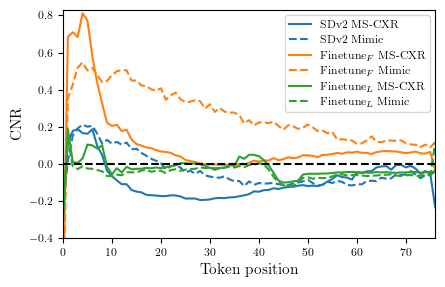

In [4]:
import matplotlib.pyplot as plt
from utils import update_matplotlib_font, set_size

update_matplotlib_font(fontsize=11, fontsize_ticks=8, tex=True)
fig, ax = plt.subplots(1, 1, figsize=set_size("MICCAI"))

c = ["#1f77b5", "#ff7f11", "#2da02d"]
for i, model in enumerate(MODELS):
    for pgm in [True, False]:
        res = experiments[model][pgm]["positional"]
        cnr = res.groupby("position").mean(numeric_only=True)["cnr"]
        #cnr_std = res.groupby("position").var(numeric_only=True)["cnr"]
        #ax.fill_between(np.arange(len(cnr)), np.array(cnr) - np.array(cnr_std), np.array(cnr) + np.array(cnr_std), color=c[i], alpha=0.2)
        linestyle = "-" if pgm else "--"

        model_name_map = {"sdv2": "SDv2", "frozen": "Finetune$_F$", "learnable":"Finetune$_L$"}
        pgm_name_map = {True: "MS-CXR", False: "Mimic"}
        label = model_name_map[model] + " " + pgm_name_map[pgm]
        ax.plot(np.arange(len(cnr)), cnr, label=label, color=c[i], linestyle=linestyle)

ax.set_ylim(-0.4, 0.83)
ax.set_xlim(0, 76)
ax.set_xlabel('Token position')
ax.set_ylabel('CNR')
ax.hlines(0, 76, 0., linestyle="--", color="black")

ax.legend()

fig.savefig(os.path.join(config.log_dir, "positional_experiment.pdf"), format='pdf', bbox_inches='tight')


Not really. Looks pretty standard. Peak in the beggining comes from tokens with high information content appearing at the begging of the sentence

# Find highest mathing word in terms of localization for each disease but only for words appearning more than 25 times in our test data


In [5]:
model = "learnable"
pgm = True
res = experiments[model][pgm]["token"]

diseases = res["finding_labels"].unique()
#diseases = ["Pneumonia",]
def str_to_float(x):
    # tensor(-1.330) --> -1.330
    if isinstance(x, float) :
        return x
    x = x.lstrip("tensor(")
    x = x.rstrip(")")
    return float(x)

mean_cnr_results =  {"disease":[], "cnr": [], "word": [], "occ": []}
res["cnr"] = res["cnr"].map(str_to_float)
for disease in diseases:
    sub_res = res[res["finding_labels"] == disease]
    word_count = sub_res["word"].value_counts()#.count()#.sort_values("rel_path", ascending=False)
    for word in list(word_count[word_count > 25].index):
        sub_res_word = sub_res[sub_res["word"] == word]
        mean_cnr_results["disease"].append(disease)
        mean_cnr_results["cnr"].append(sub_res_word["cnr"].mean())
        mean_cnr_results["word"].append(word)
        mean_cnr_results["occ"].append(len(sub_res_word))


mean_cnr_results = pd.DataFrame(mean_cnr_results)
mean_cnr_results = mean_cnr_results.sort_values(["disease", "cnr"], ascending=False)
#mean_cnr_results.to_csv(os.path.join(config.log_dir, f"{model_name}_morethan25_results.csv"))
mean_cnr_results

,disease,cnr,word,occ
20,Pneumothorax,0.954817,small,70
19,Pneumothorax,0.695520,left,85
17,Pneumothorax,0.687511,apical,119
15,Pneumothorax,0.685037,<EOS>,245
16,Pneumothorax,0.609379,pneumothorax,226
...,...,...,...,...
30,Cardiomegaly,-0.295357,is,165
32,Cardiomegaly,-0.303050,present,48
36,Atelectasis,0.803713,<EOS>,61
35,Atelectasis,-0.167359,<SOS>,61


# EOS was pretty good for learnable so check if it beats frozen

In [6]:
for model in MODELS:
    res = experiments[model][True]["token"]
    res = res[res["word"] == "<EOS>"]
    print(model)
    print(res.groupby("finding_labels").mean())
    print(res.mean())
    print("="*50)

sdv2
                   Unnamed: 0       cnr
finding_labels                         
Atelectasis       4586.131148  0.365852
Cardiomegaly      6024.396396  0.235824
Consolidation     4494.282051  0.548938
Edema             5033.869565  0.728778
Lung Opacity      7231.670732  0.546028
Pleural Effusion  8450.760417  0.026503
Pneumonia         1332.945055  0.448623
Pneumothorax      1678.000000  0.376471
Unnamed: 0    4390.054217
cnr              0.361273
dtype: float64
frozen
                   Unnamed: 0       cnr
finding_labels                         
Atelectasis       4586.131148  0.852939
Cardiomegaly      6024.396396  0.551751
Consolidation     4494.282051  1.193613
Edema             5033.869565  0.956183
Lung Opacity      7231.670732  1.064356
Pleural Effusion  8450.760417  0.448881
Pneumonia         1332.945055  0.982320
Pneumothorax      1678.000000  0.435417
Unnamed: 0    4390.054217
cnr              0.718785
dtype: float64
learnable
                   Unnamed: 0       cnr
find

/tmp/ipykernel_815009/2825003880.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(res.groupby("finding_labels").mean())
/tmp/ipykernel_815009/2825003880.py:6: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(res.mean())
/tmp/ipykernel_815009/2825003880.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(res.groupby("finding_labels").mean())
/tmp/ipykernel_815009

In [7]:
pgm = False
out_string = ""
#disease = "Pneumothorax"

words = {}
occ = {}
cnr = {}


for model in MODELS:
    res = experiments[model][pgm]["token"]


    words[model] = {}
    occ[model] = {}
    cnr[model] = {}

    for disease in diseases:
        mean_cnr_results =  {"disease":[], "cnr": [], "word": [], "occ": []}
        res["cnr"] = res["cnr"].map(str_to_float)
        sub_res = res[res["finding_labels"] == disease]
        word_count = sub_res["word"].value_counts()#.count()#.sort_values("rel_path", ascending=False)
        for word in list(word_count[word_count > 25].index):
            sub_res_word = sub_res[sub_res["word"] == word]
            mean_cnr_results["disease"].append(disease)
            mean_cnr_results["cnr"].append(sub_res_word["cnr"].mean())
            mean_cnr_results["word"].append(word)
            mean_cnr_results["occ"].append(len(sub_res_word))

        mean_cnr_results = pd.DataFrame(mean_cnr_results)
        mean_cnr_results = mean_cnr_results.sort_values(["disease", "cnr"], ascending=False)

        words[model][disease] = list(mean_cnr_results["word"][:3])
        occ[model][disease] = list(mean_cnr_results["occ"][:3])
        cnr[model][disease] = list(mean_cnr_results["cnr"][:3])


i = 0
payload_string = "& {}  & {} & {:.2f} &&  {} & {}& {:.2f} && {} &  {}& {:.2f} \\\ \n "

disease_to_short = {
     'Pneumonia':"Pnem.",
     'Pneumothorax':"Pnth.",
     'Edema':"Edem.",
     'Cardiomegaly':"Card.",
     'Atelectasis':"Atel.",
     'Consolidation':"Cons.",
     'Lung Opacity':"L-Op.",
     'Pleural Effusion':"Effu",
}

for disease in diseases:
    out_string += "\\multirow{3}{*}{" + disease_to_short[disease] + "}"
    for i in range(3):
        out_string += payload_string.format(
                             words["sdv2"][disease][i],        occ["sdv2"][disease][i],cnr["sdv2"][disease][i],
                             words["learnable"][disease][i],   occ["learnable"][disease][i],cnr["learnable"][disease][i],
                             words["frozen"][disease][i],      occ["frozen"][disease][i],cnr["frozen"][disease][i],
                            )

    out_string += "\\midrule \n"

out_string = out_string.replace("<", "").replace(">", "")
with open(os.path.join(config.log_dir, f"pgm_{pgm}_table_tokens.txt"), "w") as fp:
    fp.write(out_string)


## See if we can find a correlation between number of occurences in training data and localization

In [39]:
from tqdm import tqdm
train_dataset = get_dataset(config, "train")
occ = {}
for disease in diseases:
    occ[disease] = {}

for i in tqdm(range(len(train_dataset.meta_data))):
    if isinstance(train_dataset.meta_data.iloc[i]["Finding Labels"], float):
        continue
    findings = train_dataset.meta_data.iloc[i]["Finding Labels"].split("|")
    words = train_dataset.meta_data.iloc[i]["impression"].split(" ")
    for finding in findings:
        if finding in diseases:
            for word in words:
                word = word.lower()
                if occ[finding].get(word) is None:
                    occ[finding][word] = 0
                occ[finding][word] += 1


2023-06-22 18:58:06,617 | chest.py-meta_data-0257 | INFO | Loading image list from /vol/ideadata/ed52egek/data/mimic/jpg/physionet.org/files/mimic-cxr-jpg/2.0.0/mimic_metadata_preprocessed.csv


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186378/186378 [00:38<00:00, 4864.41it/s]


In [47]:
occ_perc = {k:{} for k in occ.keys()}
for k in occ.keys():
    for v in occ[k].keys():
        s = 0
        for d in occ.keys():
            if occ[d].get(v) is None:
                s += 0
            else:
                s += occ[d][v]

        occ_perc[k][v] = occ[k][v] / s

In [48]:
results = {}
for model in MODELS:
    res = experiments[model][True]["token"]
    mean_cnr_results =  {"disease":[], "cnr": [], "word": [], "occ": []}
    for disease in diseases:
        sub_res = res[res["finding_labels"] == disease]
        word_count = sub_res["word"].value_counts()#.count()#.sort_values("rel_path", ascending=False)
        for word in list(word_count[word_count > 25].index):
            sub_res_word = sub_res[sub_res["word"] == word]
            mean_cnr_results["disease"].append(disease)
            mean_cnr_results["cnr"].append(sub_res_word["cnr"].mean())
            mean_cnr_results["word"].append(word)
            mean_cnr_results["occ"].append(len(sub_res_word))

    mean_cnr_results = pd.DataFrame(mean_cnr_results)
    mean_cnr_results = mean_cnr_results.sort_values(["disease", "cnr"], ascending=False)
    #mean_cnr_results.to_csv(os.path.join(config.log_dir, f"{model_name}_morethan25_results.csv"))
    mean_cnr_results

    x = []
    x_train = []
    for i in range(len(mean_cnr_results)):
        disease = mean_cnr_results.iloc[i]["disease"]
        word = mean_cnr_results.iloc[i]["word"]
        #if word == "<EOS>" or word ==  "<SOS>" or word == "":
        try:
            x.append(occ[disease][word.lower()])
            x_train.append(occ_perc[disease][word.lower()])
        except KeyError:
            x.append(-1)
            x_train.append(-1)
    mean_cnr_results["occ_train"] = x
    mean_cnr_results["occ_perc"] = x_train
    res = mean_cnr_results[mean_cnr_results["occ_train"] != -1]
    results[model] = res

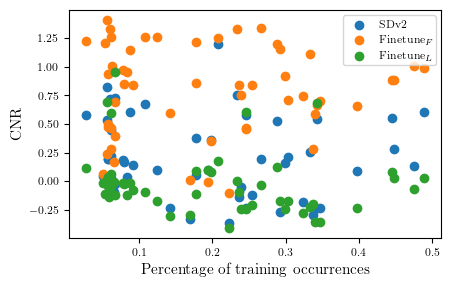

In [56]:

fig, ax = plt.subplots(1, 1, figsize=set_size("MICCAI"))

c = ["#1f77b5", "#ff7f11", "#2da02d"]
for i, model in enumerate(MODELS):

        model_name_map = {"sdv2": "SDv2", "frozen": "Finetune$_F$", "learnable":"Finetune$_L$"}
        #pgm_name_map = {True: "MS-CXR", False: "Mimic"}
        label = model_name_map[model] #+ " " + pgm_name_map[pgm]
        ax.scatter(results[model]["occ_perc"], results[model]["cnr"],label=label, color=c[i])

#ax.set_ylim(-0.4, 0.83)
#ax.set_xlim(0, 76)
ax.set_xlabel('Percentage of training occurrences')
ax.set_ylabel('CNR')
#ax.hlines(0, 76, 0., linestyle="--", color="black")

ax.legend()

fig.savefig(os.path.join(config.log_dir, "training_occ_vs_cnr.pdf"), format='pdf', bbox_inches='tight')


# OI

In [21]:
print(mean_cnr_results)

         disease       cnr          word  occ  occ_train
20  Pneumothorax  0.954817         small   70       4064
19  Pneumothorax  0.695520          left   85       8021
17  Pneumothorax  0.687511        apical  119       3471
15  Pneumothorax  0.685037         <EOS>  245         -1
16  Pneumothorax  0.609379  pneumothorax  226       4536
..           ...       ...           ...  ...        ...
30  Cardiomegaly -0.295357            is  165      39925
32  Cardiomegaly -0.303050       present   48        624
36   Atelectasis  0.803713         <EOS>   61         -1
35   Atelectasis -0.167359         <SOS>   61         -1
37   Atelectasis -0.227442   atelectasis   50      15041

[70 rows x 5 columns]
